In [285]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
#import models
from tqdm import tqdm
import train_reg
import config
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
from sklearn.model_selection import KFold
#df = data.get_tracks() # note: different Xs can be different shapes
#df = data.remove_invalid_tracks(df)
#df = data.preprocess(df)
#df = data.add_outcome(df)
#n = df.shape[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#dset = 'clath_aux_dynamin'
dset = 'clath_aux+gak_a7d2'
outcome_def = 'Y_sig_mean'
#out_dir = 'results/regression/Sep15'

In [10]:
feat_names = ['mean_square_displacement',
              'mean_total_displacement',
              'X_max',
              'X_mean',
              'X_std',
              'lifetime',
              'X_d1',
              'X_d2',
              'X_d3'
             ]

In [205]:
feat_names = data.get_feature_names(df)
feat_names = [x for x in feat_names 
                      if not x.startswith('sc_') 
                      and not x.startswith('nmf_')
                      and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max',
                                   'X_max_around_Y_peak', 'X_max_after_Y_peak', 'X_quantiles',
                                   'X_d1', 'X_d2', 'X_d3', 'slope_end'
                                   ]
                      and not x.startswith('pc_')
                      and not 'log' in x
                      and not 'binary' in x
        #               and not 'slope' in x
                     ]

In [115]:
df = pd.read_pickle(f'../data/tracks/tracks_{dset}.pkl')

In [222]:
df = data.get_data()

In [155]:
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 

In [144]:
df = train_reg.add_sig_mean(df, resp_tracks=['Y'])

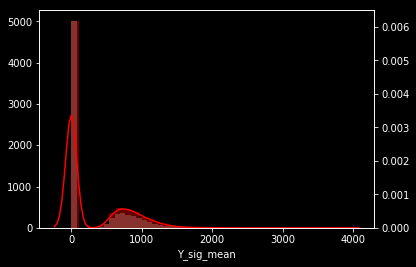

In [146]:
ax = sns.distplot(df_train[outcome_def], kde=False)
ax2 = ax.twinx()
sns.distplot(df_train[outcome_def], ax=ax2, hist=True, kde=True, 
             bins=int(180/5), color='red', label='training data')

In [278]:
#df = df[df.catIdx.isin([1, 2])]
#df = df[df.lifetime > 15]
#df = features.add_basic_features(df)
#df = train_reg.log_transforms(df)
df = features.add_dasc_features(df, bins=100, by_cell=True)
#df = outcomes.add_outcomes(df)
df = train_reg.add_sig_mean(df, resp_tracks=['Y'])
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [83]:
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 

In [279]:
df_train = df_train[df_train['valid'] == 1]

In [168]:
df = features.add_dasc_features(df, bins=100, by_cell=True)

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [169]:
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 

In [174]:
from sklearn.ensemble import RandomForestClassifier

In [181]:
m = RandomForestClassifier()
m.fit(df_train['X_d2'].values.reshape(-1, 1), df_train['y_consec_thresh'].values)

RandomForestClassifier()

In [182]:
np.mean(m.predict(df_test['X_d2'].values.reshape(-1, 1)) == df_test['y_consec_thresh'])

0.7424909891870244

In [185]:
    cell_nums_train = np.array(list(set(df_train.cell_num.values)))
    kf = KFold(n_splits=len(cell_nums_train))
    X, y = df_train[['X_d1']], df_train['y_consec_thresh']
    # split testing data based on cell num
    #idxs_test = df.cell_num.isin(cell_nums_test)
    #idxs_train = df.cell_num.isin(cell_nums_train)
    #X_test, Y_test = X[idxs_test], y[idxs_test]
    num_pts_by_fold_cv = []
    y_preds = {}
    cv_score = []
    s = 0
    # loops over cv, where test set order is cell_nums_train[0], ..., cell_nums_train[-1]
    for cv_idx, cv_val_idx in kf.split(cell_nums_train):
        # get sample indices
        idxs_cv = df_train.cell_num.isin(cell_nums_train[np.array(cv_idx)])
        idxs_val_cv = df_train.cell_num.isin(cell_nums_train[np.array(cv_val_idx)])
        X_train_cv, Y_train_cv = X[idxs_cv], y[idxs_cv]
        X_val_cv, Y_val_cv = X[idxs_val_cv], y[idxs_val_cv]
        num_pts_by_fold_cv.append(X_val_cv.shape[0])

        # resample training data

        # fit
        m.fit(X_train_cv, Y_train_cv)
        s += np.mean(m.predict(X_val_cv) == Y_val_cv)
    print(s/len(cell_nums_train))

0.5476134068254536


In [192]:
datasets = list(config.DSETS.keys())[:6]

In [ ]:
#all_data = {}
for d in datasets[2:]:
    all_data[d] = data.get_data(dset=d)

In [298]:
for d in all_data:
    #all_data[d] = train_reg.add_sig_mean(all_data[d], resp_tracks=['Y'])
    all_data[d] = features.add_dasc_features(all_data[d], bins=100, by_cell=True)

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [309]:
import collections
from collections import defaultdict
res = defaultdict(list)
for d in all_data:
    #m = pd.read_pickle(f'{out_dir}/rf.pkl')
    if d == 'clath_aux_dynamin':
        continue
    for feat in ['dasc', 'basic', 'combined']:
        out_dir = f'results/regression/Nov23_{dset}_Y_{feat}_{outcome_def}'
        m = pd.read_pickle(f'{out_dir}/rf.pkl')
        if feat == 'dasc':
            use_feature = ['X_d1', 'X_d2', 'X_d3']
        elif feat == 'basic':
            use_feature = feat_names
        else:
            use_feature = feat_names + ['X_d1', 'X_d2', 'X_d3']
        df_test = all_data[d]
        if d == 'clath_aux+gak_a7d2':
            df_test =  df_test[df_test.cell_num.isin(config.DSETS[d]['test'])] 
        #df_test = features.add_dasc_features(df_test, bins=100, by_cell=True)
        df_test = df_test[use_feature + [outcome_def]]#[df_test['valid'] == 1]
        df_test = df_test.fillna(df_test.mean())
        if len(df_test) > 0:
            test_preds = train_reg.test_reg(df_test, m['model'], feat_names=use_feature, outcome_def=outcome_def)
        #print(f"R^2 with features: {test_preds['r2']}")
        #print(f"corr with features: {test_preds['pearsonr']}")
        for metric in ['r2', 'pearsonr', 'kendalltau']:
            if metric == 'r2':
                res[f'{feat}_{metric}'].append(test_preds[metric])
            else:
                res[f'{feat}_{metric}'].append(test_preds[metric][0])

In [269]:
np.array(feat_names)[np.argsort(m['model'].feature_importances_)[::-1]]

array(['fall_extended', 'X_mean', 'mean_square_displacement', 'fall',
       'mean_total_displacement', 'X_max', 'lifetime',
       'lifetime_extended', 'rise_slope', 'rise_extended', 'min_diff',
       'X_min', 'max_diff', 'fall_slope', 'fall_local_3', 'X_std',
       'fall_late_extended', 'rise_local_3', 'X_peak_time_frac',
       'rise_local_11', 'rise', 'fall_local_11', 'X_max_extended',
       'X_peak_last_15', 'X_peak_last_5'], dtype='<U24')

In [315]:
pd.read_pickle('results/regression/regression_results.pkl')

,dasc_r2,dasc_pearsonr,dasc_kendalltau,basic_r2,basic_pearsonr,basic_kendalltau,combined_r2,combined_pearsonr,combined_kendalltau
clath_aux+gak_a7d2,0.168999,0.478137,0.365456,0.326925,0.631894,0.469760,0.339386,0.634944,0.471874
clath_aux+gak_a7d2_new,0.009576,0.161076,0.076217,0.110948,0.459541,0.244353,0.113495,0.470826,0.268349
clath_aux+gak_new,0.073963,0.288193,0.195740,0.217620,0.485779,0.304375,0.223403,0.491643,0.316647
clath_gak,-0.132353,0.219192,0.174033,0.095853,0.457564,0.344754,0.106482,0.461258,0.354777


In [290]:
all_data.keys()

dict_keys(['clath_aux+gak_a7d2', 'clath_aux+gak_a7d2_new', 'clath_aux_dynamin', 'clath_aux+gak_new', 'clath_gak'])

In [310]:
pd.DataFrame(res, index=['clath_aux+gak_a7d2', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak']).round(3).to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &  dasc\\_r2 &  dasc\\_pearsonr &  dasc\\_kendalltau &  basic\\_r2 &  basic\\_pearsonr &  basic\\_kendalltau &  combined\\_r2 &  combined\\_pearsonr &  combined\\_kendalltau \\\\\n\\midrule\nclath\\_aux+gak\\_a7d2     &    0.169 &          0.478 &            0.365 &     0.327 &           0.632 &             0.470 &        0.339 &              0.635 &                0.472 \\\\\nclath\\_aux+gak\\_a7d2\\_new &    0.010 &          0.161 &            0.076 &     0.111 &           0.460 &             0.244 &        0.113 &              0.471 &                0.268 \\\\\nclath\\_aux+gak\\_new      &    0.074 &          0.288 &            0.196 &     0.218 &           0.486 &             0.304 &        0.223 &              0.492 &                0.317 \\\\\nclath\\_gak              &   -0.132 &          0.219 &            0.174 &     0.096 &           0.458 &             0.345 &        0.106 &              0.461 &                0.355 \\\\\n\\bottom

## compare with DASC

In [311]:
#df_train = df_train.dropna()
for features in [#'dasc', 
                 #'basic', 
                 #'combined'，
                 'sparse'
                ]:
    if features == 'dasc':
        use_feature = ['X_d1', 'X_d2', 'X_d3']
    elif features == 'sparse':
        use_feature = ['mean_square_displacement',
              'mean_total_displacement',
              'X_max',
              'X_mean',
              'X_std',
              'lifetime']
    elif features == 'basic':
        use_feature = feat_names
    else:
        use_feature = feat_names + ['X_d1', 'X_d2', 'X_d3']
    #df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
    outcome_def = 'Y_sig_mean'
    out_dir = f'results/regression/Nov23_{dset}_Y_{features}_{outcome_def}'
    os.makedirs(out_dir, exist_ok=True)
    for model_type in tqdm(['linear', 'gb', 'rf', 'ridge']):
        out_name = f'{model_type}'
                            #print(out_name)
        # if use_processed and os.path.exists(f'{out_dir}/{out_name}.pkl'):
        #    continue
        train_reg.train_reg(df_train, feat_names=use_feature, model_type=model_type, 
                         outcome_def=outcome_def,
                         out_name=f'{out_dir}/{out_name}.pkl') 

100%|██████████| 4/4 [00:18<00:00,  4.53s/it]


In [314]:
out_dir = f'results/regression/Nov23_{dset}_Y_sparse_{outcome_def}'
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r['r2']

model_type
linear    0.153
ridge     0.153
gb        0.193
rf        0.165
Name: r2, dtype: float64

In [257]:
for features in [#'dasc', 
                 #'basic', 
                'combined'
                ]:
    if features == 'dasc':
        use_feature = feat_names[6:]
    elif features == 'basic':
        use_feature = feat_names[:6]
    else:
        use_feature = feat_names
    m = pd.read_pickle(f'{out_dir}/rf.pkl')
    df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 
    #df_test = df_test.dropna()
    test_preds = train_reg.test_reg(df_test, m['model'], feat_names=use_feature, outcome_def=outcome_def)
    print(f"R^2 with {features} features: {test_preds['r2']}")

R^2 with combined features: 0.34959947930075563


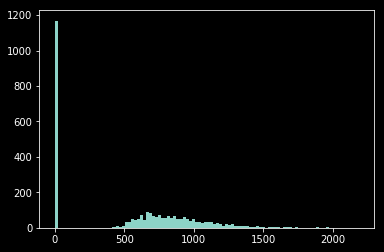

In [162]:
#df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
plt.hist(df_train['Y_sig_mean'], bins=100)
plt.show()

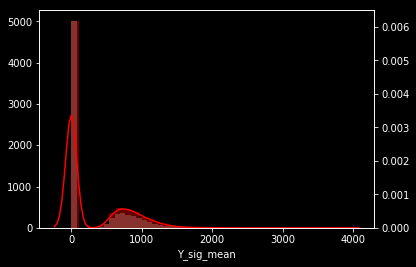

In [158]:
ax = sns.distplot(df_train[outcome_def], kde=False)
ax2 = ax.twinx()
sns.distplot(df_train[outcome_def], ax=ax2, hist=True, kde=True, 
             bins=int(180/5), color='red', label='training data')

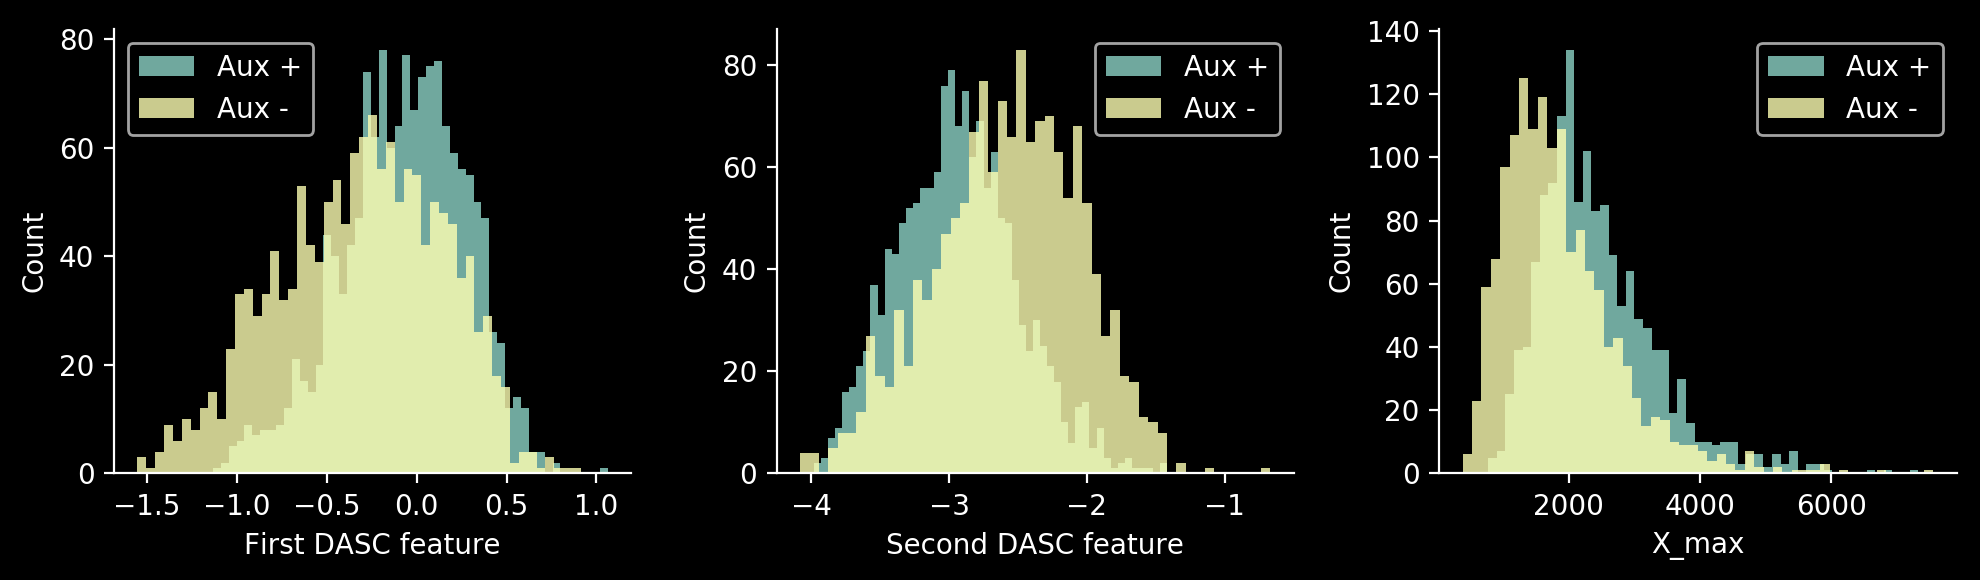

In [172]:
#plt.hist()
plt.figure(figsize=(10, 3), dpi=200)
ax = plt.subplot(1, 3, 1)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.hist(df_train['X_d1'].values[np.where(df_train['y_consec_thresh'] == True)[0]], bins=50, alpha=.8, label='Aux +')
plt.hist(df_train['X_d1'].values[np.where(df_train['y_consec_thresh'] == False)[0]], bins=50, alpha=.8, label='Aux -')
plt.legend()
plt.xlabel("First DASC feature")
plt.ylabel("Count")

ax = plt.subplot(1, 3, 2)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.hist(df_train['X_d2'].values[np.where(df_train['y_consec_thresh'] == True)[0]], bins=50, alpha=.8, label='Aux +')
plt.hist(df_train['X_d2'].values[np.where(df_train['y_consec_thresh'] == False)[0]], bins=50, alpha=.8, label='Aux -')
plt.legend()
plt.xlabel("Second DASC feature")
plt.ylabel("Count")

ax = plt.subplot(1, 3, 3)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.hist(df_train['X_max'].values[np.where(df_train['y_consec_thresh'] == True)[0]], bins=50, alpha=.8, label='Aux +')
plt.hist(df_train['X_max'].values[np.where(df_train['y_consec_thresh'] == False)[0]], bins=50, alpha=.8, label='Aux -')
plt.legend()
plt.xlabel("X_max")
plt.ylabel("Count")

plt.tight_layout()
#plt.xlim((0, 3000))
plt.show()

In [86]:
np.mean(df_train['y_consec_thresh'])

0.9096555618294748

In [74]:
np.mean((df_train['X_d2'] < -2.8) == df_train['y_consec_thresh'])

0.6498346859032161

In [31]:
df_train = outcomes.add_outcomes(df_train)

In [135]:
len(df_test[df_test[outcome_def] > 0])

819

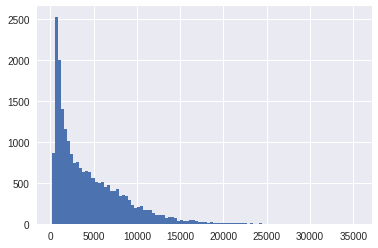

In [25]:
plt.hist(df_train['X_max'], bins=100)
plt.show()

### Max strength prediction

In [91]:
train_reg.load_and_train(dset, outcome_def, out_dir, feat_names=feat_names)

/accounts/grad/xsli/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
../src/train_reg.py:81: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05
100%|██████████| 5/5 [16:28<00:00, 182.89s/it]


In [14]:
df = train_reg.add_sig_mean(df)

../src/train_reg.py:77: RuntimeWarning: invalid value encountered in less
  sig_mean.append(0)


In [7]:
df = df[df.catIdx.isin([1, 2])]
df = df[df.lifetime > 15]

In [12]:
df = features.add_basic_features(df)
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 

In [258]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r['r2']

model_type
rf        0.322
ridge     0.258
linear    0.258
gb        0.316
Name: r2, dtype: float64

In [97]:
m = pd.read_pickle(f'{out_dir}/gb.pkl')

In [103]:
df_test = df_test.dropna()
test_preds = train_reg.test_reg(df_test, m['model'], outcome_def=outcome_def)

In [1]:
test_preds

NameError: name 'test_preds' is not defined

In [3]:
df = pd.read_pickle('../data/tracks/tracks_clath_aux_dynamin.pkl')

In [4]:
df = train_reg.add_sig_mean(df)

../src/train_reg.py:82: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05


  0%|          | 1/259739 [00:00<25:07:22,  2.87it/s]/accounts/grad/xsli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/accounts/grad/xsli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 259739/259739 [02:52<00:00, 1508.49it/s]


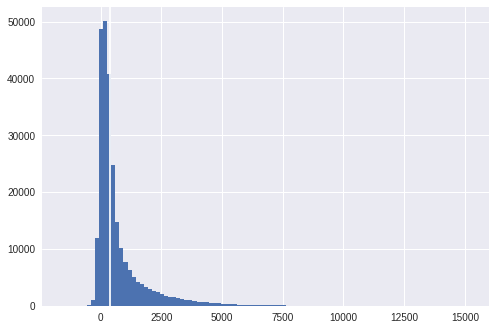

In [11]:
df['Z_max'] = [max(z) for z in df['Z']]
df['Y_max_sig'] = np.nan
df['Z_max_sig'] = np.nan
for i in tqdm(range(df.shape[0])):
    r = df.iloc[i]
    try:
        df['Y_max_sig'].iloc[i] = max(np.array(r['Y'])[np.array(r['Y_pvals']) < 0.05])
    except:
        pass
    try:
        df['Z_max_sig'].iloc[i] = max(np.array(r['Z'])[np.array(r['Z_pvals']) < 0.05])
    except:
        pass
plt.hist(df['Z_max'], bins=100)
plt.axvline(390)
plt.show()

In [168]:
df = add_dasc_features(df, bins=100, by_cell=True)

100%|██████████| 43926/43926 [00:20<00:00, 2136.02it/s]


In [178]:
df = train_reg.log_transforms(df)
df = train_reg.add_sig_mean(df)
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 
df_train = df_train.dropna()

/accounts/grad/xsli/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
../src/train_reg.py:82: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05


In [206]:
feat_names = ['mean_square_displacement',
              'mean_total_displacement',
              'X_max',
              'X_mean',
              'X_std',
              'lifetime',
              'X_d1',
              'X_d2',
              'X_d3'
             ]

In [210]:
out_dir = 'results/regression/Oct14_Z'
outcome_def = 'Z_sig_mean'
os.makedirs(out_dir, exist_ok=True)
for model_type in tqdm(['linear', 'gb', 'rf', 'ridge']):
    out_name = f'{model_type}'
                        #print(out_name)
    #if use_processed and os.path.exists(f'{out_dir}/{out_name}.pkl'):
    #    continue
    train_reg.train_reg(df_train, feat_names=feat_names, model_type=model_type, 
                     outcome_def=outcome_def,
                     out_name=f'{out_dir}/{out_name}.pkl') 

100%|██████████| 4/4 [08:39<00:00, 101.97s/it]


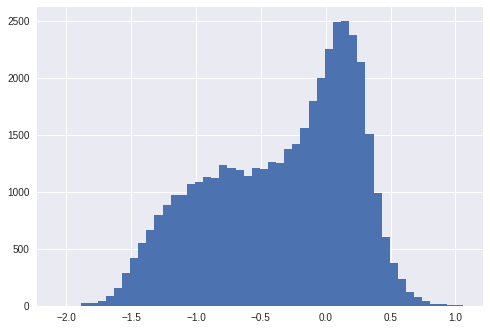

In [173]:
plt.hist(df['X_d1'], bins=50)
plt.show()